In [1]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv("output/variant_hierarchy_details.csv")

# Display column names
print("📄 Column names:")
print(df.columns.tolist())

# Sort the DataFrame by the 'Frequency' column in descending order
df_sorted = df.sort_values(by='Frequency', ascending=False)

# Display the top rows
df_sorted.head()

📄 Column names:
['Variant ID', 'Level', 'Frequency', 'Parent ID', 'Event Path']


,Variant ID,Level,Frequency,Parent ID,Event Path
0,0,0,1056,ROOT,A_Create Application → A_Submitted → W_Handle ...
7769,7769,1,1021,0,A_Create Application → W_Complete application ...
7183,7183,1,734,0,A_Create Application → A_Submitted → W_Handle ...
7184,7184,2,451,7183,A_Create Application → A_Submitted → W_Handle ...
7466,7466,2,332,7183,A_Create Application → A_Submitted → W_Handle ...


In [2]:
import os
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"

In [3]:
import hdbscan

In [4]:
import sys
print(sys.executable)

/Users/u.srinivasan/Documents/Projects/Process_Variant_Graph_BPI/variant-tree-env-py311/bin/python


In [5]:
from collections import defaultdict

# Dictionary to count event weights (weighted by frequency)
event_weights = defaultdict(int)

# Loop through each variant's event path and frequency
for path, freq in zip(df['Event Path'], df['Frequency']):
    events = [event.strip() for event in path.split("→")]
    for event in events:
        event_weights[event] += freq  # Accumulate weight by frequency

# Normalize the weights
max_weight = max(event_weights.values())
normalized_event_weights = {event: weight / max_weight for event, weight in event_weights.items()}

# Display top 10 events by normalized weight
top_events = sorted(normalized_event_weights.items(), key=lambda x: x[1], reverse=True)[:10]

print("🔥 Top 10 most common events (normalized weights):")
for event, weight in top_events:
    print(f"{event}: {weight:.3f}")

🔥 Top 10 most common events (normalized weights):
W_Call after offers: 1.000
W_Validate application: 0.920
W_Complete application: 0.760
W_Call incomplete files: 0.695
W_Handle leads: 0.245
O_Create Offer: 0.213
O_Created: 0.213
O_Sent (mail and online): 0.201
A_Validating: 0.174
A_Create Application: 0.165


,Parent,Child,Added Events,Removed Events,Add Weight,Remove Weight,Edge Weight
0,0,1550,"[W_Validate application, A_Validating, O_Returned, W_Call incomplete files, A_Incomplete, O_Accepted, A_Pending]","[A_Cancelled, O_Cancelled]",2.03449,0.01806,2.01643
1,0,9220,"[W_Validate application, A_Validating, O_Returned, W_Call incomplete files, A_Incomplete, O_Accepted, A_Pending]","[A_Submitted, W_Handle leads, A_Cancelled, O_Cancelled]",2.03449,0.09821,1.93628
2,0,405,"[W_Validate application, A_Validating, O_Returned, O_Accepted, A_Pending]","[A_Cancelled, O_Cancelled]",0.91547,0.01806,0.89741
3,0,1062,"[W_Validate application, A_Validating, O_Returned, O_Accepted, A_Pending]","[A_Submitted, W_Handle leads, A_Cancelled, O_Cancelled]",0.91547,0.09821,0.81726
4,7183,7710,[W_Complete application],[],0.43972,0.00000,0.43972
5,7184,7233,[W_Complete application],[],0.21986,0.00000,0.21986
6,7184,7191,"[W_Handle leads, W_Complete application]",[],0.14322,0.00000,0.14322
7,1550,2481,[W_Complete application],[],0.10993,0.00000,0.10993
8,7183,7184,[W_Complete application],[],0.10993,0.00000,0.10993
9,7184,7236,[W_Complete application],[],0.10993,0.00000,0.10993


/var/folders/pd/yy3pmyf5463d74mfp0yr9gsh0000gp/T/ipykernel_1698/3155527360.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


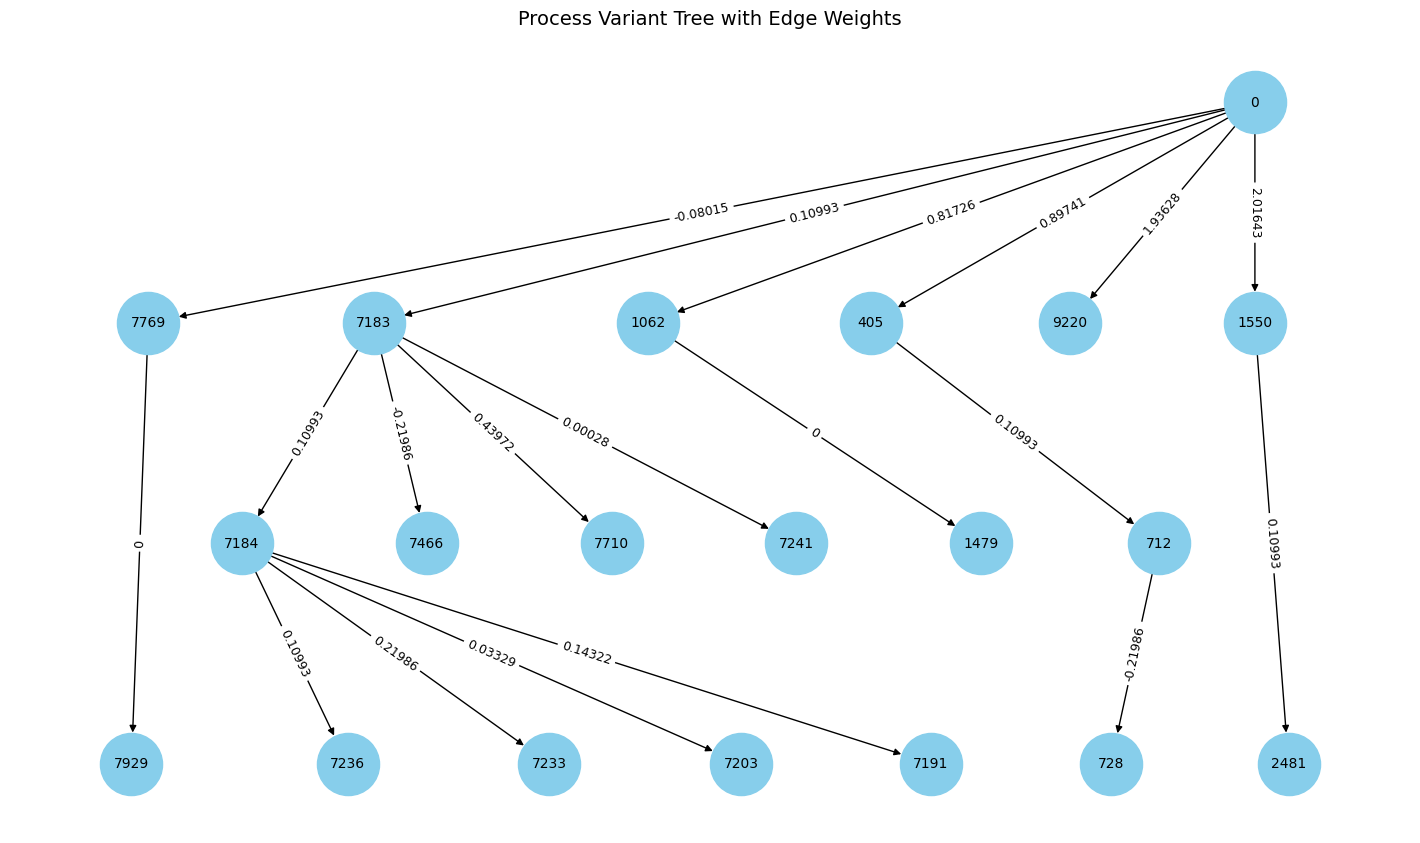

In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout

# Ensure correct types
df["Parent ID"] = df["Parent ID"].replace("ROOT", -1)
df["Parent ID"] = pd.to_numeric(df["Parent ID"], errors='coerce')
df["Variant ID"] = pd.to_numeric(df["Variant ID"], errors='coerce')

# Get top 10 variants by frequency
top_variants_df = df.sort_values(by="Frequency", ascending=False).head(20)

# Compute global event weights (normalized)
all_events = []
for path in df["Event Path"]:
    all_events.extend(path.split(" → "))

event_freq = Counter(all_events)
total_events = sum(event_freq.values())
event_weights = {e: f / total_events for e, f in event_freq.items()}

# Build variant ID to event path mapping
variant_map = {
    int(row["Variant ID"]): row["Event Path"].split(" → ")
    for _, row in df.iterrows()
}

# Compute edge weights
edge_weights = []
for _, row in top_variants_df.iterrows():
    child_id = int(row["Variant ID"])
    parent_id = int(row["Parent ID"])

    if parent_id == -1 or parent_id not in variant_map:
        continue  # skip if parent doesn't exist

    child_events = Counter(variant_map[child_id])
    parent_events = Counter(variant_map[parent_id])

    added = child_events - parent_events
    removed = parent_events - child_events

    add_weight = sum(event_weights.get(e, 0) * c for e, c in added.items())
    remove_weight = sum(event_weights.get(e, 0) * c for e, c in removed.items())
    total_weight = round(add_weight - remove_weight, 5)

    edge_weights.append({
        "Parent": parent_id,
        "Child": child_id,
        "Added Events": list(added),
        "Removed Events": list(removed),
        "Add Weight": round(add_weight, 5),
        "Remove Weight": round(remove_weight, 5),
        "Edge Weight": total_weight
    })

# ✅ Display Table
if edge_weights:
    edge_weights_df = pd.DataFrame(edge_weights)
    edge_weights_df = edge_weights_df.sort_values(by="Edge Weight", ascending=False).reset_index(drop=True)
    pd.set_option('display.max_colwidth', None)
    display(edge_weights_df)
else:
    print("⚠️ No valid parent-child relationships found among top 10 variants.")

# ✅ Visualize Tree if possible
if edge_weights:
    G = nx.DiGraph()

    # Add nodes and weighted edges
    for edge in edge_weights:
        G.add_edge(edge["Parent"], edge["Child"], weight=edge["Edge Weight"])

    pos = graphviz_layout(G, prog="dot")  # Requires pygraphviz
    edge_labels = nx.get_edge_attributes(G, 'weight')

    plt.figure(figsize=(14, 8))
    nx.draw(G, pos, with_labels=True, arrows=True,
            node_size=2000, node_color="skyblue", font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
    plt.title("Process Variant Tree with Edge Weights", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


/Users/u.srinivasan/Documents/Projects/Process_Variant_Graph_BPI/variant-tree-env-py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/u.srinivasan/Documents/Projects/Process_Variant_Graph_BPI/variant-tree-env-py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


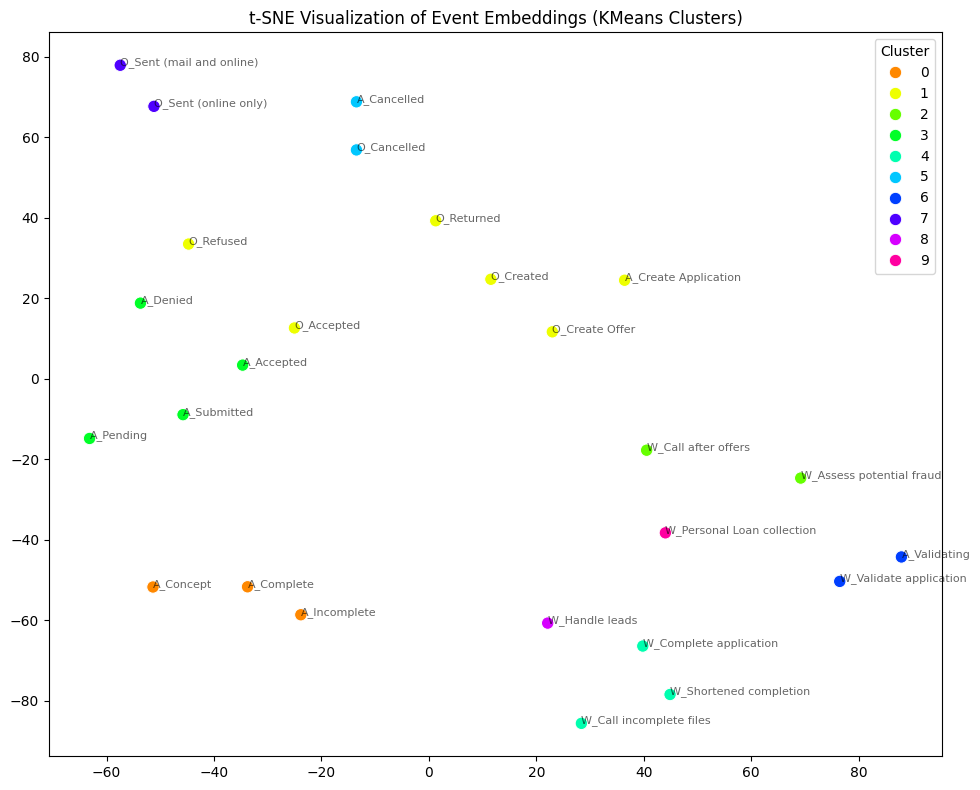

,Event,Cluster,DistanceFromCenter,Semantic Weight
4,A_Create Application,1,3.820528e-01,1.000000e+00
14,O_Refused,1,3.546683e-01,9.283227e-01
15,O_Returned,1,3.185585e-01,8.338075e-01
12,O_Create Offer,1,3.088411e-01,8.083730e-01
10,O_Accepted,1,3.031361e-01,7.934402e-01
7,A_Pending,3,3.009648e-01,7.877572e-01
5,A_Denied,3,2.975696e-01,7.788705e-01
3,A_Concept,0,2.917693e-01,7.636885e-01
20,W_Call incomplete files,4,2.796203e-01,7.318892e-01
19,W_Call after offers,2,2.762567e-01,7.230851e-01


In [7]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------
# 1. Extract unique event names
# -----------------------------------------
all_events = []
for path in df["Event Path"]:
    all_events.extend(path.split(" → "))
unique_events = sorted(set(all_events))

# -----------------------------------------
# 2. Load the embedding model
# -----------------------------------------
model = SentenceTransformer("BAAI/bge-base-en")
embeddings = model.encode(unique_events, normalize_embeddings=True)

# -----------------------------------------
# 3. Cluster with KMeans
# -----------------------------------------
k = 10  # You can tune this based on your dataset
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(embeddings)

# -----------------------------------------
# 4. Assign semantic weights (improved logic)
# -----------------------------------------
# Distance from cluster center → higher = more unique
distances = np.linalg.norm(embeddings - kmeans.cluster_centers_[labels], axis=1)

# Normalize weights: larger distance → higher weight (more anomalous)
normalized_weights = (distances - distances.min()) / (distances.max() - distances.min())

event_clusters = pd.DataFrame({
    "Event": unique_events,
    "Cluster": labels,
    "DistanceFromCenter": distances,
    "Semantic Weight": normalized_weights
})

# -----------------------------------------
# 5. Plot t-SNE for visualization
# -----------------------------------------
tsne = TSNE(n_components=2, perplexity=5, random_state=42, init="random", learning_rate="auto")
tsne_embeddings = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", k)
sns.scatterplot(
    x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1],
    hue=event_clusters["Cluster"], palette=palette, s=80, legend="full"
)
for i, txt in enumerate(event_clusters["Event"]):
    plt.annotate(txt, (tsne_embeddings[i, 0], tsne_embeddings[i, 1]), fontsize=8, alpha=0.6)
plt.title("t-SNE Visualization of Event Embeddings (KMeans Clusters)")
plt.tight_layout()
plt.show()

# -----------------------------------------
# 6. Display final dataframe
# -----------------------------------------
pd.set_option("display.max_colwidth", None)
display(event_clusters.sort_values(by="Semantic Weight", ascending=False))
